# Data Import

In [0]:
api_token = ... #REDACTED
import json
import zipfile
import os

!mkdir ~/.kaggle
!cd ~/.kaggle
!touch kaggle.json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!mkdir content
!kaggle datasets download rouzbehm/jigsawdataset -p content
!ls content

os.chdir('content')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

# Environment Setup

In [0]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split  #Import train_test_split function
from sklearn.tree import DecisionTreeClassifier  #Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

#Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report 
from sklearn.base import clone
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer #Used for vectorization

#To plot the decision tree 
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
import pydotplus
import pydot

import multiprocessing
from joblib import Parallel, delayed
import nltk
num_cores = multiprocessing.cpu_count()
from tqdm import tqdm

/usr/local/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
#Import the dataset using pandas
completeData = pd.read_csv("data.csv")

print("Dataset Length: ", len(completeData))
print("Dataset Shape: ", completeData.shape)
print("Dataset: ", completeData.head())

Dataset Length:  364500
Dataset Shape:  (364500, 4)
Dataset:     Unnamed: 0       id                                       comment_text  \
0      123886   393469  Hemp is the real thing. It really helps people...   
1      903778  5225500  A corrupt medical doctor running an electricit...   
2      964313  5297729  At best, this article is a basic description o...   
3       13965  7013965        Both Trump and China are not to be trusted.   
4       66904  7164224  Canada is one of the least prosperous Chinese ...   

   unsafe  
0       0  
1       1  
2       0  
3       0  
4       0  


In [0]:
#Seperate the target variable
data = completeData.copy()
targets = data.pop("unsafe").values

#Splitting the dataset into train and test set
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1, random_state = 123)

In [0]:
def train_and_evaluate(clf, X_train, y_train, X_test, y_test, epochs=10):
    training_scores = []
    test_scores = []
    last_clf_state = None
    num_epochs_no_change = 0
    print("Starting training and test...")
    for i in range(1, epochs + 1):
        print("Epoch:" + str(i) + "/" + str(epochs) + " -- " + str(datetime.datetime.now()))
        print("\tTraining")
        clf.fit(X_train, y_train)
        training_score = clf.score(X_train, y_train)
        training_scores.append(training_score)
        print("\tTraining Done", training_score)
        
        print("\tTesting")
        clf.predict(X_test)
        test_score = clf.score(X_test, y_test)
        print("\tTest Done", test_score)

        if (len(test_scores) > 0 and test_score < test_scores[-1]):
          print("EARLY STOP: model overfitting")
          clf = last_clf_state
          test_scores.append(test_score)
          break
        elif (len(test_scores) > 0 and test_score == test_scores[-1]):
          num_epochs_no_change += 1
          test_scores.append(test_score)

          if num_epochs_no_change == 2:
            print("EARLY STOP: no change")
            break
        else:
          test_scores.append(test_score)
          last_clf_state = clone(clf)

    print("Done training and test.")
    return (training_scores,test_scores)

def plotScores(scores_train, scores_test,title=""):
    # Plot the points
    plt.plot([i + 1 for i in range(len(scores_train))], scores_train,marker='o')
    plt.plot([i + 1 for i in range(len(scores_test))], scores_test,marker='o')
    # Setup the legend
    plt.legend(["Train scores", "Test Scores"])
    plt.title(title)
    # Labels for the x and y axis
    plt.ylabel("Score")
    plt.xlabel("Epoch")
    plt.grid()
    plt.show()

#### Use of a TFIDF vectorizer to process the comments into a vector representation

In [0]:
tfid_vect = TfidfVectorizer()
train_tfid_vect = tfid_vect.fit_transform(train_data["comment_text"])
test_tfid_vect = tfid_vect.transform(test_data["comment_text"])

print(len(list(tfid_vect.vocabulary_.items())))

tfidList = list(tfid_vect.vocabulary_.items())
featureList = [x[0] for x in tfidList]

162153


# Decision Trees

### Results using Gini Index

Gini index is used to minimize the probability of misclassification. In particular, the Gini Impurity of a node is the probability that a randomly chosen sample in a node would be incorrectly labeled if it was labeled according to the distribution of samples in the node.

In [0]:
# Creating the classifier object 
clf_gini = DecisionTreeClassifier(criterion = "gini") 
# Performing training 
clf_gini_scores = train_and_evaluate(clf_gini, train_tfid_vect, train_targets, test_tfid_vect, test_targets) 

Starting training and test...
Epoch:1/10 -- 2019-12-03 23:38:53.497989
	Training
	Training Done 0.9994299649443682
	Testing
	Test Done 0.786803840877915
Epoch:2/10 -- 2019-12-04 00:19:29.931942
	Training
	Training Done 0.9994299649443682
	Testing
	Test Done 0.7872427983539094
Epoch:3/10 -- 2019-12-04 01:15:21.196287
	Training
	Training Done 0.9994299649443682
	Testing
	Test Done 0.7902057613168725
Epoch:4/10 -- 2019-12-04 01:54:02.797928
	Training
	Training Done 0.9994299649443682
	Testing
	Test Done 0.7908367626886146
Epoch:5/10 -- 2019-12-04 02:21:40.954916
	Training
	Training Done 0.9994299649443682
	Testing
	Test Done 0.7901234567901234
EARLY STOP: model overfitting
Done training and test.


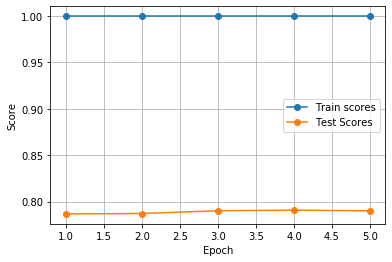

In [0]:
plotScores(clf_gini_scores[0],clf_gini_scores[1])

In [0]:
# Predicton on test with giniIndex 
y_pred_gini = clf_gini.predict(test_tfid_vect) 
print("Predicted values:") 
print(y_pred_gini) 

# Functions to calculate the accuracy, precision, recall and f1 sore
print("Confusion Matrix: ", 
      confusion_matrix(test_targets, y_pred_gini)) 
      
print ("Accuracy : ", 
       accuracy_score(test_targets, y_pred_gini)) 

print("Precision : ", 
      precision_score(test_targets, y_pred_gini))

print("Recall : ", 
      recall_score(test_targets, y_pred_gini))

print("F1 Score : ", 
      f1_score(test_targets, y_pred_gini))
      
print("Report : ", 
      classification_report(test_targets, y_pred_gini)) 

Predicted values:
[0 0 0 ... 0 0 0]
Confusion Matrix:  [[14431  3777]
 [ 3873 14369]]
Accuracy :  0.7901234567901234
Precision :  0.7918549542598919
Recall :  0.7876877535357966
F1 Score :  0.7897658568758932
Report :                precision    recall  f1-score   support

           0       0.79      0.79      0.79     18208
           1       0.79      0.79      0.79     18242

    accuracy                           0.79     36450
   macro avg       0.79      0.79      0.79     36450
weighted avg       0.79      0.79      0.79     36450



In [0]:
from sklearn.metrics import precision_recall_fscore_support
scores = precision_recall_fscore_support(test_targets, y_pred_gini)
print("Precision:")
print("\tSafe:", scores[0][0])
print("\tUnsafe:", scores[0][1])
print("Recall:")
print("\tSafe:", scores[1][0])
print("\tUnsafe:", scores[1][1])
print("F1 Score:")
print("\tSafe:", scores[2][0])
print("\tUnsafe:", scores[2][1])
print("Support:")
print("\tSafe:", scores[3][0])
print("\tUnsafe:", scores[3][1])

Precision:
	Safe: 0.7884069055944056
	Unsafe: 0.7918549542598919
Recall:
	Safe: 0.7925637082601055
	Unsafe: 0.7876877535357966
F1 Score:
	Safe: 0.790479842243646
	Unsafe: 0.7897658568758932
Support:
	Safe: 18208
	Unsafe: 18242


### Results using Entropy

Entropy is another way to measure impurity. Entropy controls how the Decision Tree decides to split the data, in particular, how it draws its boundaries.

In [0]:
# Decision tree with entropy 
clf_entropy = DecisionTreeClassifier(criterion = "entropy") 
  
# Performing training 
clf_entropy_scores = train_and_evaluate(clf_entropy, train_tfid_vect, train_targets, test_tfid_vect, test_targets) 

Starting training and test...
Epoch:1/10 -- 2019-12-04 08:45:18.299963
	Training
	Training Done 0.9994299649443682
	Testing
	Test Done 0.7672976680384088
Epoch:2/10 -- 2019-12-04 09:10:17.311544
	Training
	Training Done 0.9994299649443682
	Testing
	Test Done 0.7671056241426611
EARLY STOP: model overfitting
Done training and test.


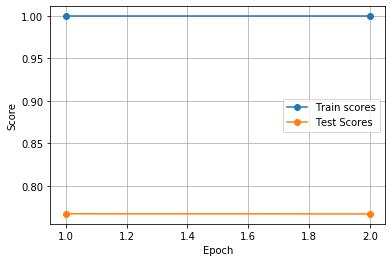

In [0]:
plotScores(clf_entropy_scores[0],clf_entropy_scores[1])

In [0]:
# Prediciton using entropy
y_pred_entropy = clf_entropy.predict(test_tfid_vect)
print("Preficted values:")
print(y_pred_entropy)

# Functions to calculate the accuracy, precision, recall and f1 sore
print("Confusion Matrix: ", 
      confusion_matrix(test_targets, y_pred_entropy)) 
      
print ("Accuracy : ", 
       accuracy_score(test_targets, y_pred_entropy)) 

print("Precision : ", 
      precision_score(test_targets, y_pred_entropy))

print("Recall : ", 
      recall_score(test_targets, y_pred_entropy))

print("F1 Score : ", 
      f1_score(test_targets, y_pred_entropy))
      
print("Report : ", 
      classification_report(test_targets, y_pred_entropy)) 

Preficted values:
[1 0 0 ... 1 1 0]
Confusion Matrix:  [[14082  4126]
 [ 4363 13879]]
Accuracy :  0.7671056241426611
Precision :  0.7708414329352957
Recall :  0.7608266637430107
F1 Score :  0.7658013076944299
Report :                precision    recall  f1-score   support

           0       0.76      0.77      0.77     18208
           1       0.77      0.76      0.77     18242

    accuracy                           0.77     36450
   macro avg       0.77      0.77      0.77     36450
weighted avg       0.77      0.77      0.77     36450



In [0]:
from sklearn.metrics import precision_recall_fscore_support
scores = precision_recall_fscore_support(test_targets, y_pred_entropy)
print("Precision:")
print("\tSafe:", scores[0][0])
print("\tUnsafe:", scores[0][1])
print("Recall:")
print("\tSafe:", scores[1][0])
print("\tUnsafe:", scores[1][1])
print("F1 Score:")
print("\tSafe:", scores[2][0])
print("\tUnsafe:", scores[2][1])
print("Support:")
print("\tSafe:", scores[3][0])
print("\tUnsafe:", scores[3][1])

Precision:
	Safe: 0.7634589319598807
	Unsafe: 0.7708414329352957
Recall:
	Safe: 0.773396309314587
	Unsafe: 0.7608266637430107
F1 Score:
	Safe: 0.7683954928655227
	Unsafe: 0.7658013076944299
Support:
	Safe: 18208
	Unsafe: 18242


# Random Forest

### Baseline with No Parameters

We initially used the default parameters when training the model using a function from Sklearn.

In [0]:
rf = RandomForestClassifier(n_estimators=100)
# Performing training 
rf_scores = train_and_evaluate(rf, train_tfid_vect, train_targets, test_tfid_vect, test_targets) 

Starting training and test...
Epoch:1/10 -- 2019-12-06 10:34:01.861881
	Training
	Training Done 0.9994269166285628
	Testing
	Test Done 0.8265843621399177
Epoch:2/10 -- 2019-12-06 15:00:15.651695
	Training


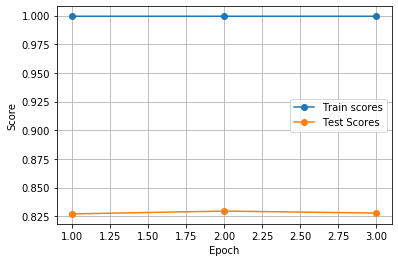

In [0]:
plotScores(rf_scores[0],rf_scores[1])

In [0]:
predicted = rf.predict(test_tfid_vect)

print("Confusion Matrix: ", 
      confusion_matrix(test_targets, predicted)) 

print ("Accuracy : ", 
       accuracy_score(test_targets, predicted)) 

print("Precision : ", 
      precision_score(test_targets, predicted))

print("Recall : ", 
      recall_score(test_targets, predicted))

print("F1 Score : ", 
      f1_score(test_targets, predicted))

NameError: name 'rf' is not defined

In [0]:
from sklearn.metrics import precision_recall_fscore_support
scores_rf = precision_recall_fscore_support(test_targets, predicted)
print("Precision:")
print("\tSafe:", scores_rf[0][0])
print("\tUnsafe:", scores_rf[0][1])
print("Recall:")
print("\tSafe:", scores_rf[1][0])
print("\tUnsafe:", scores_rf[1][1])
print("F1 Score:")
print("\tSafe:", scores_rf[2][0])
print("\tUnsafe:", scores_rf[2][1])
print("Support:")
print("\tSafe:", scores_rf[3][0])
print("\tUnsafe:", scores_rf[3][1])

Precision:
	Safe: 0.8063803554916265
	Unsafe: 0.8521549693829487
Recall:
	Safe: 0.8620935852372583
	Unsafe: 0.7933888827979388
F1 Score:
	Safe: 0.833306789828529
	Unsafe: 0.8217225912678136
Support:
	Safe: 18208
	Unsafe: 18242


### Classifier using bootstrapping and max number of features

In attempt to increase the accuracy score, parameter were defined including the random sampling on training observations using bootstrapping, and random subsets of features for splitting nodes. 

In [0]:
rf_random = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
# Performing training 
rf_random_scores = rf_random.fit(train_tfid_vect, train_targets) 


In [0]:
predicted_random = rf_random.predict(test_tfid_vect)

print("Confusion Matrix: ", 
      confusion_matrix(test_targets, predicted_random)) 

print ("Accuracy : ", 
       accuracy_score(test_targets, predicted_random)) 

print("Precision : ", 
      precision_score(test_targets, predicted_random))

print("Recall : ", 
      recall_score(test_targets, predicted_random))

print("F1 Score : ", 
      f1_score(test_targets, predicted_random))

Accuracy :  0.8246639231824417
Precision :  0.8506420498254335
Recall :  0.7880166648393816
F1 Score :  0.8181326655473663


In [0]:
from sklearn.metrics import precision_recall_fscore_support
scores_rf_random = precision_recall_fscore_support(test_targets, predicted_random)
print("Precision:")
print("\tSafe:", scores_rf_random[0][0])
print("\tUnsafe:", scores_rf_random[0][1])
print("Recall:")
print("\tSafe:", scores_rf_random[1][0])
print("\tUnsafe:", scores_rf_random[1][1])
print("F1 Score:")
print("\tSafe:", scores_rf_random[2][0])
print("\tUnsafe:", scores_rf_random[2][1])
print("Support:")
print("\tSafe:", scores_rf_random[3][0])
print("\tUnsafe:", scores_rf_random[3][1])

Precision:
	Safe: 0.80220960564677
	Unsafe: 0.8506420498254335
Recall:
	Safe: 0.8613796133567663
	Unsafe: 0.7880166648393816
F1 Score:
	Safe: 0.8307423395746709
	Unsafe: 0.8181326655473663
Support:
	Safe: 18208
	Unsafe: 18242


### Random Forest Regressor with no parameters

Unfortunately the random forest regressor was too computationally heavy and took over 6 hours to execute. After waiting patiently, it was in our best interest to stop the execution and continue executing the rest of the script 

In [0]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state = 42)
# Performing training 
#rf_reg_scores = train_and_evaluate(rf_reg, train_tfid_vect, train_targets, test_tfid_vect, test_targets) 
rf_reg_scores = rf_reg.fit(train_tfid_vect, train_targets) 

In [0]:
predicted_reg = rf_reg.predict(test_tfid_vect)

print("Confusion Matrix: ", 
      confusion_matrix(test_targets, predicted_reg)) 

print ("Accuracy : ", 
       accuracy_score(test_targets, predicted_reg)) 

print("Precision : ", 
      precision_score(test_targets, predicted_reg))

print("Recall : ", 
      recall_score(test_targets, predicted_reg))

print("F1 Score : ", 
      f1_score(test_targets, predicted_reg))

In [0]:
from sklearn.metrics import precision_recall_fscore_support
scores_rf_reg = precision_recall_fscore_support(test_targets, predicted_reg)
print("Precision:")
print("\tSafe:", scores_rf_reg[0][0])
print("\tUnsafe:", scores_rf_reg[0][1])
print("Recall:")
print("\tSafe:", scores_rf_reg[1][0])
print("\tUnsafe:", scores_rf_reg[1][1])
print("F1 Score:")
print("\tSafe:", scores_rf_reg[2][0])
print("\tUnsafe:", scores_rf_reg[2][1])
print("Support:")
print("\tSafe:", scores_rf_reg[3][0])
print("\tUnsafe:", scores_rf_reg[3][1])

# Natural Language Processing

Now that we've established that random forest outperforms a decision tree, we can perform natural language processing techniques on our text. We will start by setting up a function that returns the Random Forest Classifier model. 

In [0]:
def forest_model():
    return RandomForestClassifier(n_estimators=100)

def vectorize(train_data, test_data): 
    tfidf_vect = TfidfVectorizer()
    train_tfidf_vect = tfidf_vect.fit_transform(train_data)
    test_tfidf_vect = tfidf_vect.transform(test_data)
    return train_tfidf_vect, test_tfidf_vect

def score(predictions, targets=test_targets):
    conf = confusion_matrix(targets, predictions)
    acc = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions)
    recall = recall_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    conf = confusion_matrix(targets, predictions)

    
    print("Accuracy:", acc)
    print("Precision:",precision)
    print("Recall:",recall)
    print("F1 Score:",f1)
    print("Confusion Matrix:", conf)

    return (acc,precision,recall,f1,conf)

In [0]:
from nltk import word_tokenize
nltk.download('punkt')
import re

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sarahkhalaf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### NLP Pipeline (Alphanumeric Only)

The first technique involved filtering tokens that did not have alphanumeric characters.

In [0]:
#Tokenize the comments 
no_alpha_comment_test = train_data.iloc[0]["comment_text"]
no_alpha_comment_test_tok = word_tokenize(no_alpha_comment_test.lower())

#Remove words that do not match the alphanumeric regex pattern ^[a-zA-Z]+$
no_alpha_comment_test_tok = [tok for tok in no_alpha_comment_test_tok if re.match("^[a-zA-Z]+$", tok)]
no_alpha_comment_test_text = " ".join(no_alpha_comment_test_tok)

In [0]:
#Define a function to apply to all comments
def remove_non_alphanum(comment):
    comment_tok = word_tokenize(comment)

    comment_alpha = [tok for tok in comment_tok if re.match("^[a-zA-Z]+$", tok)]

    comment_text = " ".join(comment_alpha)
    return comment_text

def no_alpnum(comments, parallel=True):
    if parallel:
        new_comments = Parallel(n_jobs=num_cores)(delayed(remove_non_alphanum)(comment)for comment in tqdm(comments,position=0))
    else:
        new_comments = []
        for comment in tqdm(comments, position=0, leave=True):
            
            new_comments.append(comment_text)

    return np.array(new_comments)

In [0]:
train_data_alpha = no_alpnum(train_data["comment_text"])
test_data_alpha = no_alpnum(test_data["comment_text"])

100%|██████████| 36450/36450 [00:22<00:00, 1642.59it/s]


In [0]:
train_tfidf_vect_alpha,test_tfidf_vect_alpha = vectorize(train_data_alpha,test_data_alpha)

In [0]:
rf_alpha = RandomForestClassifier(n_estimators=100)
# Performing training 
rf_alpha_scores = train_and_evaluate(rf_alpha, train_tfidf_vect_alpha, train_targets, test_tfidf_vect_alpha, test_targets) 
#rf_alpha_scores = rf_alpha.fit(train_tfidf_vect_alpha, train_targets) 

Starting training and test...
Epoch:1/10 -- 2019-12-05 22:33:40.213906
	Training
	Training Done 0.9992257277853985
	Testing
	Test Done 0.8255692729766804
Epoch:2/10 -- 2019-12-06 00:14:21.927009
	Training
	Training Done 0.9992257277853985
	Testing
	Test Done 0.8237311385459534
EARLY STOP: model overfitting
Done training and test.


In [0]:
rf_alpha_pred = rf_alpha.predict(test_tfidf_vect_alpha)

In [0]:
rf_alpha_results = score(rf_alpha_pred)

Accuracy: 0.8237311385459534
Precision: 0.8519687853696313
Recall: 0.7840149106457626
F1 Score: 0.8165805475463189
Confusion Matrix: [[15723  2485]
 [ 3940 14302]]


In [0]:
from sklearn.metrics import precision_recall_fscore_support
scores_rf_alpha = precision_recall_fscore_support(test_targets, rf_alpha_pred)
print("Precision:")
print("\tSafe:", scores_rf_alpha[0][0])
print("\tUnsafe:", scores_rf_alpha[0][1])
print("Recall:")
print("\tSafe:", scores_rf_alpha[1][0])
print("\tUnsafe:", scores_rf_alpha[1][1])
print("F1 Score:")
print("\tSafe:", scores_rf_alpha[2][0])
print("\tUnsafe:", scores_rf_alpha[2][1])
print("Support:")
print("\tSafe:", scores_rf_alpha[3][0])
print("\tUnsafe:", scores_rf_alpha[3][1])

Precision:
	Safe: 0.7996236586482226
	Unsafe: 0.8519687853696313
Recall:
	Safe: 0.8635215289982425
	Unsafe: 0.7840149106457626
F1 Score:
	Safe: 0.8303451189564575
	Unsafe: 0.8165805475463189
Support:
	Safe: 18208
	Unsafe: 18242


### NLP Pipeline (Stopword Removal)

The next NLP technique was removing stopwords. The English stopwords from NLTK was used as a corpus and any tokens a part of that corpus was removed from the comments.

In [0]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarahkhalaf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def remove_stopword(comment):
    comment_tok = word_tokenize(comment)
    filtered_comment_tok = [w for w in comment_tok if not w in stopwords.words('english')] 
    comment_text = " ".join(filtered_comment_tok)
    return comment_text


def no_stopword(comments):
    new_comments = Parallel(n_jobs=num_cores)(delayed(remove_stopword)(comment)for comment in tqdm(comments,position=0))

    return np.array(new_comments)

In [0]:
train_data_stopwords = no_stopword(train_data["comment_text"])
test_data_stopwords = no_stopword(test_data["comment_text"])

100%|██████████| 36450/36450 [03:29<00:00, 173.66it/s]


In [0]:
train_tfidf_vect_stopwords,test_tfidf_vect_stopwords = vectorize(train_data_stopwords,test_data_stopwords)

In [0]:
rf_stopwords = RandomForestClassifier(n_estimators=100)
# Performing training 
rf_stopwords_scores = train_and_evaluate(rf_stopwords, train_tfidf_vect_stopwords, train_targets, test_tfidf_vect_stopwords, test_targets) 
#rf_stopwords_scores = rf_stopwords.fit(train_tfidf_vect_stopwords, train_targets) 

Starting training and test...
Epoch:1/10 -- 2019-12-06 05:01:52.698516
	Training
	Training Done 0.9993446121018138
	Testing
	Test Done 0.8537997256515775
Epoch:2/10 -- 2019-12-06 06:41:11.737093
	Training
	Training Done 0.9993415637860082
	Testing
	Test Done 0.8547050754458162
Epoch:3/10 -- 2019-12-06 08:20:19.374562
	Training
	Training Done 0.9993446121018138
	Testing
	Test Done 0.8540740740740741
EARLY STOP: model overfitting
Done training and test.


In [0]:
rf_stopwords_pred = rf_stopwords.predict(test_tfidf_vect_stopwords)

In [0]:
rf_stopwords_results = score(rf_stopwords_pred)

Accuracy: 0.8540740740740741
Precision: 0.8631076144984546
Recall: 0.8419581186273435
F1 Score: 0.8524016982545717
Confusion Matrix: [[15772  2436]
 [ 2883 15359]]


In [0]:
from sklearn.metrics import precision_recall_fscore_support
scores_rf_stopwords = precision_recall_fscore_support(test_targets, rf_stopwords_pred)
print("Precision:")
print("\tSafe:", scores_rf_stopwords[0][0])
print("\tUnsafe:", scores_rf_stopwords[0][1])
print("Recall:")
print("\tSafe:", scores_rf_stopwords[1][0])
print("\tUnsafe:", scores_rf_stopwords[1][1])
print("F1 Score:")
print("\tSafe:", scores_rf_stopwords[2][0])
print("\tUnsafe:", scores_rf_stopwords[2][1])
print("Support:")
print("\tSafe:", scores_rf_stopwords[3][0])
print("\tUnsafe:", scores_rf_stopwords[3][1])


Precision:
	Safe: 0.8454569820423479
	Unsafe: 0.8631076144984546
Recall:
	Safe: 0.8662126537785588
	Unsafe: 0.8419581186273435
F1 Score:
	Safe: 0.8557089764804818
	Unsafe: 0.8524016982545717
Support:
	Safe: 18208
	Unsafe: 18242


### NLP Pipeline (Nouns Only)

The last NLP technique used was removing all words except those tagged as nouns. Once the comments were tokenized, the parts of speech were tagged using the NLTK wordnet, and only those tagged as a noun were kept. 

In [0]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sarahkhalaf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sarahkhalaf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
from nltk.corpus import wordnet

def noun_only_comment(comment):
    comment_tokens = word_tokenize(comment)

    posTokens = nltk.pos_tag(comment_tokens)

    noun_only_comment = [tok[0] for tok in posTokens if tok[1][0] == 'N']
    
    comment_text = " ".join(noun_only_comment)
    return comment_text

def noun_only_comments(comments, parallel=True):
    if parallel:
        new_comments = Parallel(n_jobs=num_cores)(delayed(noun_only_comment)(comment)for comment in tqdm(comments,position=0))
    else:
        new_comments = []
        for comment in tqdm(comments, position=0):
            new_comment = adj_only_comment(comment)
            new_comments.append(new_comment)
    
    return np.array(new_comments)

In [0]:
train_data_noun = noun_only_comments(train_data["comment_text"])
test_data_noun = noun_only_comments(test_data["comment_text"])

100%|██████████| 36450/36450 [01:08<00:00, 532.88it/s]


In [0]:
tfidf_vect_noun = TfidfVectorizer()
train_tfidf_vect_noun = tfidf_vect_noun.fit_transform(train_data_noun)
test_tfidf_vect_noun = tfidf_vect_noun.transform(test_data_noun)

In [0]:
rf_noun = RandomForestClassifier(n_estimators=100)
# Performing training 
rf_noun_scores = train_and_evaluate(rf_noun, train_tfidf_vect_noun, train_targets, test_tfidf_vect_noun, test_targets) 
#rf_noun_scores = rf_noun.fit(train_tfidf_vect_stopwords, train_targets) 

Starting training and test...
Epoch:1/10 -- 2019-12-05 15:41:23.488468
	Training
	Training Done 0.9880963267794544
	Testing
	Test Done 0.7688340192043895
Epoch:2/10 -- 2019-12-05 17:58:06.213533
	Training
	Training Done 0.9880963267794544
	Testing
	Test Done 0.7705075445816186
Epoch:3/10 -- 2019-12-05 20:15:45.965171
	Training
	Training Done 0.9880963267794544
	Testing
	Test Done 0.7698216735253772
EARLY STOP: model overfitting
Done training and test.


In [0]:
rf_noun_pred = rf_noun.predict(test_tfidf_vect_noun)

In [0]:
rf_noun_results = score(rf_noun_pred)

Accuracy: 0.7698216735253772
Precision: 0.7928308167875401
Recall: 0.7311150093191536
F1 Score: 0.7607232489162675
Confusion Matrix: [[14723  3485]
 [ 4905 13337]]


In [0]:
from sklearn.metrics import precision_recall_fscore_support
scores_rf_noun = precision_recall_fscore_support(test_targets, rf_noun_pred)
print("Precision:")
print("\tSafe:", scores_rf_noun[0][0])
print("\tUnsafe:", scores_rf_noun[0][1])
print("Recall:")
print("\tSafe:", scores_rf_noun[1][0])
print("\tUnsafe:", scores_rf_noun[1][1])
print("F1 Score:")
print("\tSafe:", scores_rf_noun[2][0])
print("\tUnsafe:", scores_rf_noun[2][1])
print("Support:")
print("\tSafe:", scores_rf_noun[3][0])
print("\tUnsafe:", scores_rf_noun[3][1])


Precision:
	Safe: 0.7501018952516812
	Unsafe: 0.7928308167875401
Recall:
	Safe: 0.8086006151142355
	Unsafe: 0.7311150093191536
F1 Score:
	Safe: 0.7782535151707368
	Unsafe: 0.7607232489162675
Support:
	Safe: 18208
	Unsafe: 18242
